# Large-Scale Stochastic Variational GP Regression in 1D (w/ KISS-GP)

## Introduction

This example shows how to perform GP regression, but using **variational inference** rather than exact inference. There are a few cases where variational inference may be prefereable:

1) If you have lots of data, and want to perform **stochastic optimization**

2) If you have a model where you want to use other variational distributions

KISS-GP with SVI was introduced in:
https://papers.nips.cc/paper/6426-stochastic-variational-deep-kernel-learning.pdf

**NOTE: Variational inference in GPyTorch is still in its early stages - and the interface is likely to change in the near future!**

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Create a training set
# We're going to learn a sine function
train_x = torch.linspace(0, 1, 1000)
train_y = torch.sin(train_x * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2

## Performing SGD - the dataloader

Because we want to do stochastic optimization, we have to put the dataset in a pytorch **DataLoader**.
This creates easy minibatches of the data

In [3]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## The model

This is pretty similar to a normal regression model, except now we're using a `gpytorch.models.GridInducingVariationalGP` instead of a `gpytorch.models.ExactGP`.

Any of the variational models would work. We're using the `GridInducingVariationalGP` because we have many data points, but only 1 dimensional data.

Similar to exact regression, we use a `GaussianLikelihood`.

In [4]:
class GPRegressionModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPRegressionModel, self).__init__(grid_size=20, grid_bounds=[(-0.05, 1.05)])
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                log_lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-3), math.exp(6), sigma=0.1, log_transform=True
                )
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
model = GPRegressionModel()
likelihood = gpytorch.likelihoods.GaussianLikelihood()

## The training loop

This training loop will use **stochastic optimization** rather than batch optimization

In [5]:
model.train()
likelihood.train()

# We'll do 40 iterations of optimization
n_iter = 40

# We use SGD here, rather than Adam
# Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.SGD([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# We use a Learning rate scheduler from PyTorch to lower the learning rate during optimization
# We're going to drop the learning rate by 1/10 after 3/4 of training
# This helps the model converge to a minimum
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.75 * n_iter], gamma=0.1)

# Our loss object
# We're using the VariationalMarginalLogLikelihood object
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, num_data=train_y.size(0))

# The training loop
def train():
    for i in range(n_iter):
        scheduler.step()
        
        # Within each iteration, we will go over each minibatch of data
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            # We're going to use two context managers here
            
            # The use_toeplitz flag makes learning faster on the GPU (trades off memory for speed)
            # The diagonal_correction flag improves the approximations we're making for variational inference
            # It makes running time a bit slower, but improves the optimization and predictions
            with gpytorch.settings.use_toeplitz(False), gpytorch.beta_features.diagonal_correction():
                output = model(x_batch)
                loss = -mll(output, y_batch)
                print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
            
            # The actual optimization step
            loss.backward()
            optimizer.step()
            
%time train()

Iter 1/40 - Loss: 16.507
Iter 1/40 - Loss: 14.814
Iter 1/40 - Loss: 13.362
Iter 1/40 - Loss: 12.253
Iter 1/40 - Loss: 11.350
Iter 1/40 - Loss: 10.589
Iter 1/40 - Loss: 10.041
Iter 1/40 - Loss: 9.489
Iter 1/40 - Loss: 9.229
Iter 1/40 - Loss: 8.890
Iter 1/40 - Loss: 8.636
Iter 1/40 - Loss: 8.443
Iter 1/40 - Loss: 8.226
Iter 1/40 - Loss: 8.060
Iter 1/40 - Loss: 7.951
Iter 1/40 - Loss: 7.818
Iter 2/40 - Loss: 7.903
Iter 2/40 - Loss: 7.655
Iter 2/40 - Loss: 7.674
Iter 2/40 - Loss: 7.692
Iter 2/40 - Loss: 7.594
Iter 2/40 - Loss: 7.442
Iter 2/40 - Loss: 7.513
Iter 2/40 - Loss: 7.542
Iter 2/40 - Loss: 7.500
Iter 2/40 - Loss: 7.446
Iter 2/40 - Loss: 7.397
Iter 2/40 - Loss: 7.441
Iter 2/40 - Loss: 7.400
Iter 2/40 - Loss: 7.396
Iter 2/40 - Loss: 7.320
Iter 2/40 - Loss: 7.338
Iter 3/40 - Loss: 7.260
Iter 3/40 - Loss: 7.354
Iter 3/40 - Loss: 7.250
Iter 3/40 - Loss: 7.378
Iter 3/40 - Loss: 7.325
Iter 3/40 - Loss: 7.363
Iter 3/40 - Loss: 7.334
Iter 3/40 - Loss: 7.314
Iter 3/40 - Loss: 7.261
Iter 3/40

Iter 22/40 - Loss: 5.967
Iter 22/40 - Loss: 5.740
Iter 22/40 - Loss: 5.819
Iter 22/40 - Loss: 5.780
Iter 22/40 - Loss: 5.905
Iter 22/40 - Loss: 5.873
Iter 22/40 - Loss: 6.096
Iter 22/40 - Loss: 5.941
Iter 22/40 - Loss: 5.955
Iter 22/40 - Loss: 5.883
Iter 22/40 - Loss: 5.761
Iter 23/40 - Loss: 5.946
Iter 23/40 - Loss: 5.901
Iter 23/40 - Loss: 5.902
Iter 23/40 - Loss: 5.846
Iter 23/40 - Loss: 5.959
Iter 23/40 - Loss: 5.769
Iter 23/40 - Loss: 5.855
Iter 23/40 - Loss: 5.931
Iter 23/40 - Loss: 5.872
Iter 23/40 - Loss: 5.831
Iter 23/40 - Loss: 5.785
Iter 23/40 - Loss: 5.920
Iter 23/40 - Loss: 5.856
Iter 23/40 - Loss: 5.828
Iter 23/40 - Loss: 5.783
Iter 23/40 - Loss: 6.061
Iter 24/40 - Loss: 5.973
Iter 24/40 - Loss: 5.776
Iter 24/40 - Loss: 5.817
Iter 24/40 - Loss: 5.790
Iter 24/40 - Loss: 5.778
Iter 24/40 - Loss: 6.038
Iter 24/40 - Loss: 5.949
Iter 24/40 - Loss: 5.936
Iter 24/40 - Loss: 5.813
Iter 24/40 - Loss: 5.878
Iter 24/40 - Loss: 5.838
Iter 24/40 - Loss: 5.747
Iter 24/40 - Loss: 5.917


## Testing the model

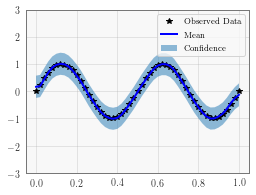

In [6]:
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 1, 51)
test_y = torch.sin(test_x * (4 * math.pi))
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.beta_features.diagonal_correction():
    observed_pred = likelihood(model(test_x))

lower, upper = observed_pred.confidence_region()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(test_x.detach().cpu().numpy(), test_y.detach().cpu().numpy(), 'k*')
ax.plot(test_x.detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'b')
ax.fill_between(test_x.detach().cpu().numpy(), lower.detach().cpu().numpy(), upper.detach().cpu().numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])